# Processing DeWeirdt 2020

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

In [2]:
reads = (pd.read_csv('../data/raw/DeWeirdt2020_AACC03_reads.csv')
         .drop('Gene ID', axis=1)
         .rename({'Construct Barcode': 'sgRNA Sequence'}, axis=1))
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])

In [3]:
read_cols = ['AACC03_pDNA_1', 'AACC03_pDNA_2', 
             'A375_Dropout_Rep A', 'A375_Dropout_Rep B', 
             'MELJUSO_Dropout_Rep A', 'MELJUSO_Dropout_Rep B', 
             'HT29_Dropout_Rep A', 'HT29_Dropout_Rep B']
lognorms = pool.lognorm_columns(reads_df=reads, columns=read_cols)
pdna_cols = ['AACC03_pDNA_1', 'AACC03_pDNA_2']
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=pdna_cols, z_low=-3)
filtered_lognorms['pDNA_avg'] = filtered_lognorms[pdna_cols].mean(axis=1)
filtered_lognroms = filtered_lognorms.drop(pdna_cols, axis=1)
lognorms.shape[0] - filtered_lognorms.shape[0]

70

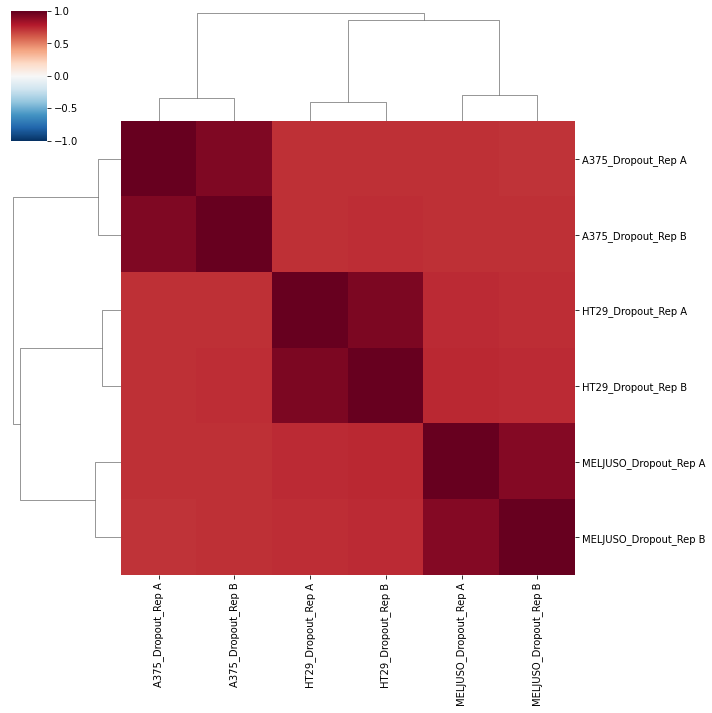

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognroms, ref_col='pDNA_avg', 
                             target_cols=['A375_Dropout_Rep A', 'A375_Dropout_Rep B', 
                                          'MELJUSO_Dropout_Rep A', 'MELJUSO_Dropout_Rep B', 
                                          'HT29_Dropout_Rep A', 'HT29_Dropout_Rep B'])
lfc_cors = lfc_df.corr()
sns.clustermap(lfc_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [5]:
sg_list = list(lfc_df['sgRNA Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [6]:
long_lfcs = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence', 
                                        condition_indices=[0], sep = '_')

In [7]:
lfcs_designs = (long_lfcs
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
tp_genes = essential_genes.gene
fp_genes = ['CD81', 'CD33', 'FAS', 'ICAM1']
pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=tp_genes, 
                  fp_genes=fp_genes, gene_col='Target Gene Symbol', 
                  score_col='avg_lfc', group_col='condition')

,condition,ROC-AUC
0,A375,0.835274
1,HT29,0.883865
2,MELJUSO,0.895752


In [8]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(tp_genes)]
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))
sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                     'Target Cut %', 'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'))
               .reset_index())

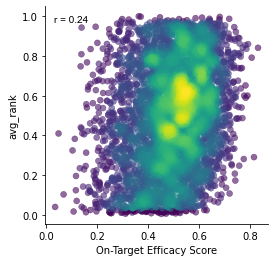

In [9]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
sns.despine()

In [10]:
training_data = sg_avg_rank.drop('On-Target Efficacy Score', axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_rank
0,AAAAAATGTTGGCCTCTCTT,TTTCAAAAAATGTTGGCCTCTCTTTGGATC,BRCA2,0.2,0.768612
1,AAAAAATTATGCTGAATACC,GATTAAAAAATTATGCTGAATACCAGGTAG,KPNB1,75.6,0.332121
2,AAAAACGTAAAAATGGAAAT,ACCTAAAAACGTAAAAATGGAAATTGGTAA,BRCA2,64.1,0.179074
3,AAAAATACACATTTGAGGTA,AGAGAAAAATACACATTTGAGGTATGGATT,CUL3,79.8,0.686801
4,AAAAATATGTAAACAGCATT,GATGAAAAATATGTAAACAGCATTTGGGAC,CUL3,4.2,0.263982
...,...,...,...,...,...
4625,TTTGTCACTTCCACTCTCAA,AGATTTTGTCACTTCCACTCTCAAAGGGCT,BRCA2,11.0,0.447351
4626,TTTGTCCAGGAAGTTGTCCA,ACAATTTGTCCAGGAAGTTGTCCAGGGCAG,EEF2,99.1,0.134318
4627,TTTGTGTAGCTGTATACGTA,TTATTTTGTGTAGCTGTATACGTATGGCGT,BRCA2,74.3,0.366868
4628,TTTGTTCTCATTAGGTAAAA,ATGGTTTGTTCTCATTAGGTAAAAAGGTGG,POLR1C,77.6,0.078947


In [11]:
training_data.to_csv('../data/processed/DeWeirdt2020_activity.csv', index=False)